# CS5588 Hands-On Sep 10th 2024
## Student name: Namuun Lkhagvadorj

## Dataset: https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests/data

## Source Code and model I could use: https://www.kaggle.com/code/purvasingh/text-generation-via-rnn-and-lstms-pytorch

### I tried to do sentiment analysis based on the financial news 6000+ dataset and used LSTM as the backbone model

In [3]:
!pip install yfinance
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import re
import yfinance as yf
import holidays
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [2]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import CosineDecay

from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [23]:
import torch.nn.functional as F
def SentimentAnalyzer(doc):
    pt_batch = tokenizer(doc,padding=True,truncation=True,max_length=512,return_tensors="pt")
    outputs = model(**pt_batch)
    pt_predictions = F.softmax(outputs.logits, dim=-1)
    return pt_predictions.detach().cpu().numpy()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
data1 = pd.read_csv('/content/drive/MyDrive/CS5588_Hand-On/data/analyst_ratings_processed.csv', index_col=0)
data1 = data1.reset_index()
data1

,index,title,date,stock
0,0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05 10:30:00-04:00,A
1,1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03 10:45:00-04:00,A
2,2.0,71 Biggest Movers From Friday,2020-05-26 04:30:00-04:00,A
3,3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22 12:45:00-04:00,A
4,4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22 11:38:00-04:00,A
...,...,...,...,...
1400464,1413844.0,Top Narrow Based Indexes For August 29,2011-08-29 10:41:00-04:00,ZX
1400465,1413845.0,Recap: Wednesday's Top Percentage Gainers and ...,2011-06-22 16:44:00-04:00,ZX
1400466,1413846.0,UPDATE: Oppenheimer Color on China Zenix Auto ...,2011-06-21 08:26:00-04:00,ZX
1400467,1413847.0,Oppenheimer Initiates China Zenix At Outperfor...,2011-06-21 05:59:00-04:00,ZX


# **Preprocessing data**

In [12]:
data1 = data1.drop("index", axis = 1)
data1 = data1.drop(index = data1[data1.isna()["stock"]].index)
data1[data1.isna()["stock"]].index

Index([], dtype='int64')

In [14]:
data1.rename(columns={'stock':'ticker'}, inplace=True)
data1['date'] = data1['date'].apply(lambda x : x.split()[0])

In [15]:
data = data1
data.drop_duplicates(subset='title', keep='first', inplace=True)

In [16]:
data["ticker"].value_counts()

,count
ticker,
BABA,2398
EBAY,2214
BBRY,2093
EWU,2006
AGN,1991
...,...
FGM,1
FIDU,1
NVX,1


In [17]:
data1[data1["ticker"] == 'BABA']["date"].value_counts()

,count
date,
2016-08-12,21
2015-08-12,18
2015-12-09,16
2015-10-16,13
2018-08-23,12
...,...
2018-10-19,1
2018-10-15,1
2017-01-29,1


In [19]:
tickerSymbol = "BABA"
tmpData = {}
total = data['date'].nunique()
for i in tqdm(data[data['ticker']==tickerSymbol]['date'].unique()):
    tmpData[i] = data.loc[(data['ticker']==tickerSymbol) & (data['date'] == i)]['title'].tolist()

100%|██████████| 1003/1003 [03:05<00:00,  5.42it/s]


In [20]:
ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()
def next_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    next_day = datetimeObj + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

In [21]:
def findPercentageBySentences(sentenceList):
    posAvg, negAvg, neuAvg = 0, 0, 0
    sentimentArr = SentimentAnalyzer(sentenceList)
    sentimentArr = np.mean(sentimentArr, axis=0)
    posAvg=sentimentArr[0]
    negAvg=sentimentArr[1]
    neuAvg=sentimentArr[2]
    return {'numArticles': len(sentenceList), 'pos': posAvg, 'neg': negAvg, 'neu' : neuAvg}

In [24]:
dateSentimentGroups = {}
for i in tqdm(tmpData):
    scores = findPercentageBySentences(tmpData[i])
    dateSentimentGroups[i] = scores

100%|██████████| 1003/1003 [05:57<00:00,  2.80it/s]


In [25]:
data = []
ticker = yf.Ticker(tickerSymbol)
hist = ticker.history(period="max")
hist_ri = hist
hist_ri = hist_ri.reset_index()

window_size = 8

for i in tqdm(dateSentimentGroups):
# for i in list(dateSentimentGroups):
    start = i
    nextDay = next_business_day(start).strftime("%Y-%m-%d")
    index = hist_ri[hist_ri["Date"] == i].index
    try:
        prevDay = hist.iloc[(index - window_size)[0] : index[0]]
#         print(hist.iloc[(index - window_size)[0] : index[0]])
        nextDay = hist.loc[nextDay]
        #     data.append([i, dateSentimentGroups[i]['numArticles'], dateSentimentGroups[i]['neu'], dateSentimentGroups[i]['pos'], dateSentimentGroups[i]['neg'], percentageChange])
        data.append([dateSentimentGroups[i]['numArticles'], dateSentimentGroups[i]['neu'], dateSentimentGroups[i]['pos'], dateSentimentGroups[i]['neg']] + list(prevDay['Close']) + [nextDay['Close']])
    except:
        pass
#         print(i)

100%|██████████| 1003/1003 [00:01<00:00, 842.17it/s]


In [27]:
open_col_tuple = tuple(["Close" + str(i + 1) for i in range(window_size)])
['numArticles', 'neutral', 'positive','negative',open_col_tuple, 'Close']
df = pd.DataFrame(columns =['numArticles', 'neutral', 'positive','negative','Close1','Close2','Close3','Close4','Close5','Close6','Close7','Close8', 'Close'], data=data)

# **LSTM model**

In [29]:
X = df[['neutral', 'positive', 'negative','Close1','Close2','Close3','Close4','Close5','Close6','Close7','Close8']]
y = df['Close']

In [30]:
n_timesteps = 8
close_cols = ['Close1', 'Close2', 'Close3', 'Close4', 'Close5', 'Close6', 'Close7', 'Close8']
close_data = df[close_cols].values
n_samples = close_data.shape[0]
close_data = close_data.reshape(n_samples, n_timesteps)

In [32]:
target = df['Close'].values
target

array([207.86730957, 216.01820374, 213.15959167, 210.57138062,
       206.98847961, 200.28619385, 192.65678406, 194.28890991,
       194.81040955, 192.85960388, 204.89280701, 209.36421204,
       209.76016235, 207.90592957, 192.62782288, 194.29856873,
       199.61982727, 196.7129364 , 200.23789978, 204.86383057,
       205.37567139, 197.76559448, 191.21783447, 181.13543701,
       182.13014221, 182.10118103, 179.38743591, 170.29975891,
       172.7237854 , 178.75971985, 192.09666443, 199.32044983,
       190.88948059, 204.21678162, 204.69966125, 203.7532196 ,
       200.87528992, 198.0070343 , 198.56716919, 205.30807495,
       210.57138062, 214.53096008, 212.96644592, 212.10693359,
       212.81192017, 216.62663269, 209.76982117, 208.37915039,
       209.1131134 , 213.3334198 , 212.67671204, 215.24560547,
       199.51359558, 201.43544006, 204.75759888, 203.02891541,
       198.43196106, 211.62406921, 214.75306702, 219.63973999,
       217.35092163, 218.73196411, 222.58528137, 214.18

In [33]:
scaler = MinMaxScaler(feature_range=(0,1))
rdata = scaler.fit_transform(np.concatenate([close_data,target.reshape(-1,1)],axis = 1))

In [34]:
X_rdata = rdata[:, :n_timesteps]
y = rdata[:, n_timesteps:]

In [35]:
sentiment_cols = ['neutral', 'positive', 'negative']
sentiment_data = df[sentiment_cols].values

In [36]:
n_features = len(sentiment_cols) + 1
X = np.zeros((n_samples, n_timesteps, n_features))
for i in range(n_timesteps):
    X[:, i, :len(sentiment_cols)] = sentiment_data
    X[:, i, len(sentiment_cols):] = X_rdata[:, i : (i + 1)]

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [38]:
window_size = n_timesteps

def build_and_compile_model_LSTM():
    model=Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1 + len(sentiment_cols))))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))
    model.compile(loss='mean_squared_error', optimizer = Adam())
    return model

In [39]:
LSTM_model = build_and_compile_model_LSTM()
LSTM_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8, 50)               │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,451 (200.98 KB)

 Trainable params: 51,451 (200.98 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = LSTM_model.fit(X_train, y_train, validation_split=0.2, shuffle=False,  epochs = 20)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0076 - val_loss: 0.0543
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0065 - val_loss: 0.0310
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0055 - val_loss: 0.0141
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0

In [42]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
#   plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Closing Price]')
  plt.legend()
  plt.grid(True)

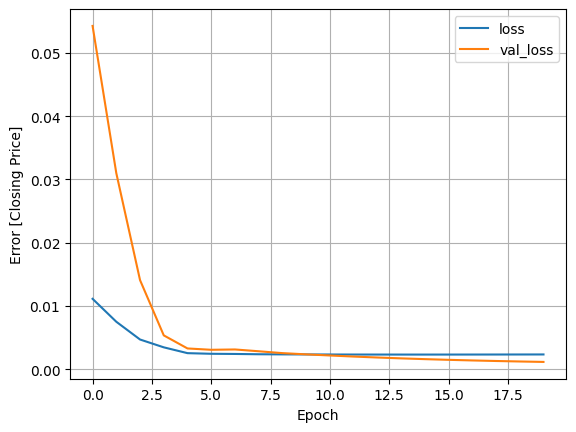

In [43]:
plot_loss(history)

In [44]:
preds = LSTM_model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


In [45]:
LSTM_model.evaluate(X_test, y_test, verbose=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 


0.0017161743016913533

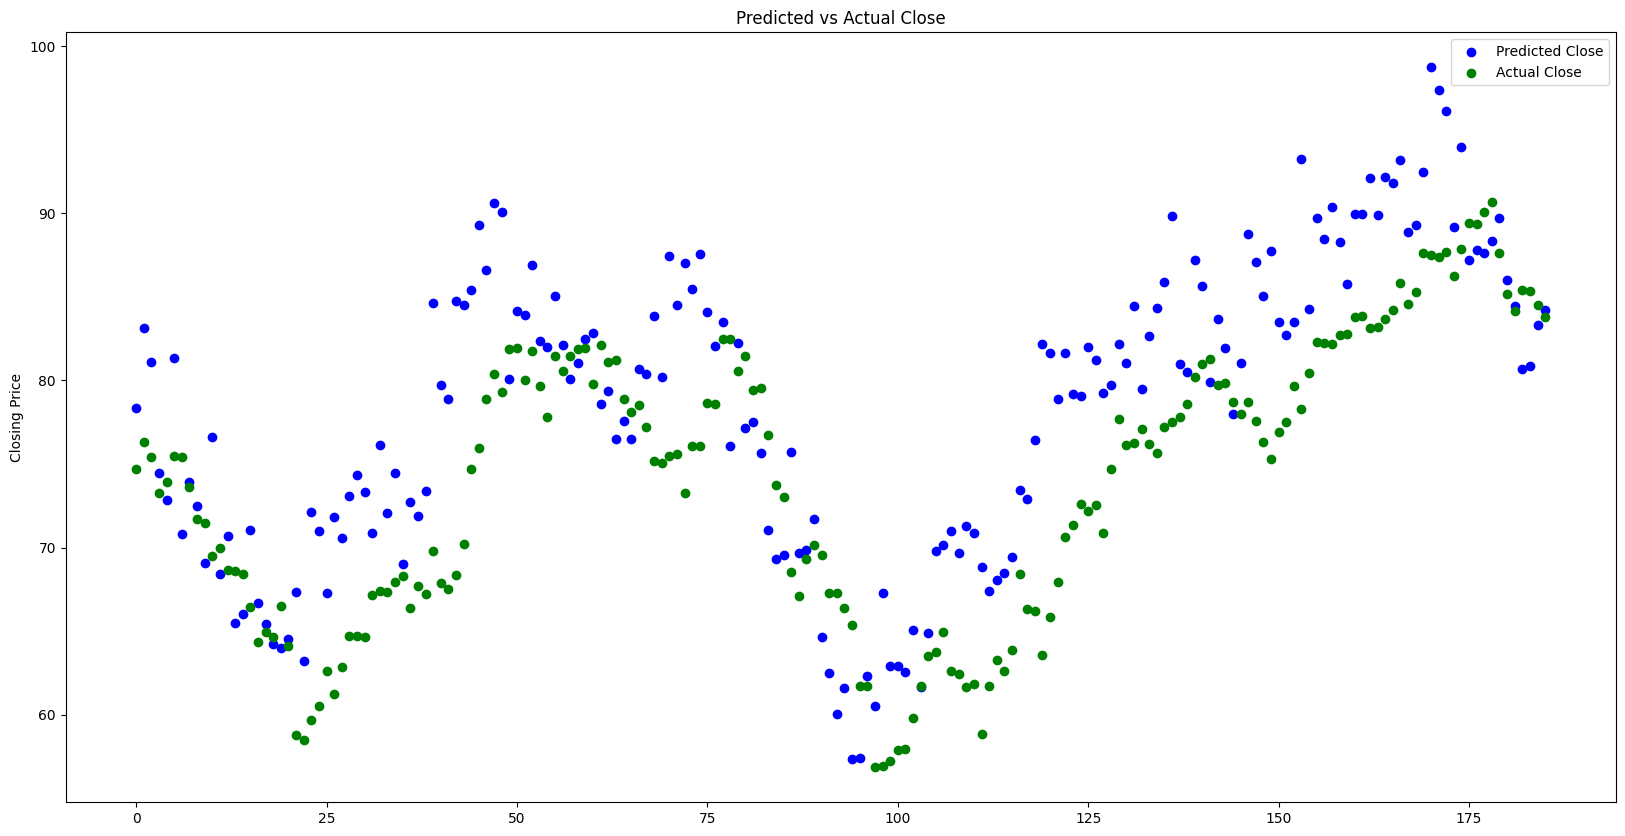

In [48]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
X = [i for i in range(len(preds))]

# Assign variables to the y axis part of the curve
y = scaler.inverse_transform(np.concatenate([X_rdata[X_rdata.shape[0] - y_test.shape[0]:,:], preds],axis = 1))[:,-1:]
z = scaler.inverse_transform(np.concatenate([X_rdata[X_rdata.shape[0] - y_test.shape[0]:,:], y_test],axis = 1))[:,-1:]

# Plotting both the curves simultaneously
plt.scatter(X, y, color='b', label='Predicted Close')
plt.scatter(X, z, color='g', label='Actual Close')

# Naming the x-axis, y-axis and the whole graph
plt.ylabel("Closing Price")
plt.title("Predicted vs Actual Close")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()